In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("accident_info.csv")

In [3]:
df.shape

(425, 11)

In [4]:
df.head()

,Unnamed: 0,Data,Countries,Local,Industry Sector,Accident Level,Potential Accident Level,Genre,Employee or Third Party,Critical Risk,Description
0,0,2016-01-01 00:00:00,Country_01,Local_01,Mining,I,IV,Male,Third Party,Pressed,While removing the drill rod of the Jumbo 08 f...
1,1,2016-01-02 00:00:00,Country_02,Local_02,Mining,I,IV,Male,Employee,Pressurized Systems,During the activation of a sodium sulphide pum...
2,2,2016-01-06 00:00:00,Country_01,Local_03,Mining,I,III,Male,Third Party (Remote),Manual Tools,In the sub-station MILPO located at level +170...
3,3,2016-01-08 00:00:00,Country_01,Local_04,Mining,I,I,Male,Third Party,Others,Being 9:45 am. approximately in the Nv. 1880 C...
4,4,2016-01-10 00:00:00,Country_01,Local_04,Mining,IV,IV,Male,Third Party,Others,Approximately at 11:45 a.m. in circumstances t...


In [5]:
df.Description[3]

'Being 9:45 am. approximately in the Nv. 1880 CX-695 OB7, the personnel begins the task of unlocking the Soquet bolts of the BHB machine, when they were in the penultimate bolt they identified that the hexagonal head was worn, proceeding Mr. Cristóbal - Auxiliary assistant to climb to the platform to exert pressure with your hand on the "DADO" key, to prevent it from coming out of the bolt; in those moments two collaborators rotate with the lever in anti-clockwise direction, leaving the key of the bolt, hitting the palm of the left hand, causing the injury.'

In [6]:
df.groupby('Industry Sector').count()

,Unnamed: 0,Data,Countries,Local,Accident Level,Potential Accident Level,Genre,Employee or Third Party,Critical Risk,Description
Industry Sector,,,,,,,,,,
Metals,134,134,134,134,134,134,134,134,134,134
Mining,241,241,241,241,241,241,241,241,241,241
Others,50,50,50,50,50,50,50,50,50,50


In [7]:
df.Description.head()

0    While removing the drill rod of the Jumbo 08 f...
1    During the activation of a sodium sulphide pum...
2    In the sub-station MILPO located at level +170...
3    Being 9:45 am. approximately in the Nv. 1880 C...
4    Approximately at 11:45 a.m. in circumstances t...
Name: Description, dtype: object

In [8]:
import pre_processor as pp

[nltk_data] Downloading package wordnet to /Users/chethee/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/chethee/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
from sklearn.model_selection import train_test_split

In [10]:
prepare_data = pp.pre_process_data()

In [11]:
df['modified_description'] = prepare_data.pre_process(df.Description,                    
                                                        lower_flag=1, 
                                                        remove_spaces_flag=1, 
                                                        remove_new_line_flag=1,
                                                        remove_special_char_flag=1,  
                                                        remove_single_letter_word_flag=1,
                                                        remove_two_letter_word_flag=1,
                                                        remove_numbers_flag=1,  
                                                        remove_stop_words_flag=1,  
                                                        replace_appos_flag=1,
                                                        lemmatize_the_words_flag=0, 
                                                        stem_the_words_flag=0)

In [12]:
df['modified_description'].head()

0    removing drill rod jumbo maintenance superviso...
1    activation sodium sulphide pump piping uncoupl...
2    substation milpo located level collaborator ex...
3    approximately cx personnel begins task unlocki...
4    approximately circumstances mechanics anthony ...
Name: modified_description, dtype: object

In [13]:
df['Potential Accident Level'].head()

0     IV
1     IV
2    III
3      I
4     IV
Name: Potential Accident Level, dtype: object

In [14]:
df['Potential Accident Level'].unique()

array(['IV', 'III', 'I', 'II', 'V', 'VI'], dtype=object)

In [15]:
df['PAL_label'] = df['Potential Accident Level'].replace({'I' :0, 'II':1, 'III':2, 'IV':3, 'V':4, 'VI':4})

In [16]:
df.PAL_label.unique()

array([3, 2, 0, 1, 4])

In [17]:
X_train, X_test, y_train, y_test = train_test_split(df.modified_description.values, df.PAL_label.values, test_size=0.2, random_state=53)

In [18]:
print('training dataset length: {}'.format(X_train.shape[0]))
print('test dataset length: {}'.format(X_test.shape[0]))

training dataset length: 340
test dataset length: 85


In [19]:
print(set(y_train))

{0, 1, 2, 3, 4}


### Building LSTM Model

In [20]:
import tensorflow as tf
from keras.utils.np_utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation, Flatten,Embedding, LSTM, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.metrics import accuracy_score, classification_report

In [21]:
import model_efficiency as me

#### Creating Sequences and padding for data

In [22]:
embedding_dim = 50
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

In [23]:
tokenizer = Tokenizer(num_words=5000, oov_token=oov_tok)
tokenizer.fit_on_texts(df.modified_description.values)
word_index = tokenizer.word_index

X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_train_padded = pad_sequences(X_train_sequences, maxlen = max_length, padding=padding_type, truncating=trunc_type)

X_test_sequences = tokenizer.texts_to_sequences(X_test)
X_test_padded = pad_sequences(X_test_sequences, maxlen = max_length, padding=padding_type, truncating=trunc_type)

In [24]:
print(X_train_padded.shape, X_test_padded.shape)

(340, 100) (85, 100)


In [25]:
len(word_index)

2987

In [26]:
vocab_size = len(word_index)

In [27]:
print(set(y_train))

{0, 1, 2, 3, 4}


In [28]:
y_train_cat = to_categorical(y_train,5)
y_test_cat = to_categorical(y_test,5)

In [29]:
print(y_train_cat[0:3])

[[0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]]


#### implementing glove embeddings

In [30]:
embeddings_index = {}
with open('glove.6B.50d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word]=coefs

In [31]:
# initialize a matrix of zeros and then assign the encoding for the words in the vocabulary to the appropriate index in the embedding_matrix
embeddings_matrix = np.zeros((vocab_size+1, embedding_dim))
for key in sorted(word_index, key=word_index.get)[:vocab_size]:
    embedding_vector = embeddings_index.get(key)
    if embedding_vector is not None:
        embeddings_matrix[word_index[key]] = embedding_vector

In [32]:
embeddings_matrix.shape

(2988, 50)

In [33]:
#First 3 words and the corresponding index from the word_index dictionary which holds the vocabulary

for key in sorted(word_index, key=word_index.get)[:3]:
    print(key,end=' ')
    print(word_index.get(key))

<OOV> 1
hand 2
causing 3


In [34]:
# Embeddings for the first 3 words

for key in sorted(word_index, key=word_index.get)[:3]:
    print(key,end=' ')
    print(embeddings_index.get(key))

<OOV> None
hand [ 0.088068  -0.42703    0.21275   -0.46137    0.88653    0.31964
 -0.0094923  0.12259   -0.011234  -0.2113    -0.11769    0.085932
 -0.54004    0.27666   -0.074244   0.11298   -0.31362   -0.30666
  0.13833   -0.99789   -0.10509    0.56499    0.30105   -0.60911
  0.21528   -1.9955    -0.23075    0.36169    0.36569   -0.83593
  3.1593     0.38484   -0.58786    0.30266   -0.080106   0.7723
  0.14527    0.54844    0.13905   -0.15815    0.37559    0.64325
 -0.35815    0.2687     0.37035   -0.12839    0.14046   -0.37389
 -0.24085   -0.80756  ]
causing [ 1.0024   -0.30473   0.59768   0.11346  -0.57746   1.223     0.62224
  0.90865   0.5732    0.036871  0.41451  -0.33117  -0.11585  -0.3285
  0.36742   0.42193  -0.20847  -0.26701  -0.86066  -0.6179    0.11827
 -0.47762   0.18215  -0.31493   0.33446  -1.2224    0.16317   0.5404
  1.4502    0.50994   2.6965    0.43596   0.89297  -0.90865  -0.68426
  0.53641   0.13307  -0.94249   0.84191   0.75849  -0.69839   0.50504
  0.076961  0.

In [35]:
embeddings_matrix[word_index['causing']]

array([ 1.00240004, -0.30473   ,  0.59767997,  0.11346   , -0.57745999,
        1.22300005,  0.62224001,  0.90864998,  0.57319999,  0.036871  ,
        0.41451001, -0.33116999, -0.11585   , -0.3285    ,  0.36741999,
        0.42192999, -0.20847   , -0.26701   , -0.86066002, -0.61790001,
        0.11827   , -0.47762001,  0.18215001, -0.31492999,  0.33445999,
       -1.22239995,  0.16316999,  0.54040003,  1.45019996,  0.50994003,
        2.69650006,  0.43595999,  0.89297003, -0.90864998, -0.68426001,
        0.53640997,  0.13307001, -0.94248998,  0.84191   ,  0.75849003,
       -0.69839001,  0.50503999,  0.076961  ,  0.16066   ,  0.75919002,
       -0.031439  , -0.15232   , -0.3696    ,  0.47086   , -0.71793997])

In [36]:
def model_nlp():
    model = tf.keras.Sequential([
        Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix]),
        LSTM(64, return_sequences=True),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.2),
        Dense(128, activation='relu'),
        Dense(5, activation='softmax')
    ])

    optimizer = Adam(lr=0.001)
    model.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])
    model.summary
    return model

In [37]:
def model_train(x_train,y_train,x_val, y_val):
    esc = EarlyStopping(patience=5, verbose=1, monitor='val_loss')
    rlp = ReduceLROnPlateau(min_lr=0.00001, factor=0.1, patience=3, monitor='val_loss', verbose=1)
    mc = ModelCheckpoint("model", save_best=True, save_weights_only=True)
    cl_model = model_nlp()
    history = cl_model.fit(x_train, y_train, validation_data=(x_val, y_val), callbacks=[ esc, rlp, mc], batch_size=50, epochs =30 , verbose = 1)
    return cl_model, history

In [38]:
cl_model, history=model_train(X_train_padded,y_train_cat, X_test_padded, y_test_cat)

Epoch 1/30
7/7 [==============================] - 4s 262ms/step - loss: 1.5322 - accuracy: 0.2930 - val_loss: 1.4197 - val_accuracy: 0.4353
Epoch 2/30
7/7 [==============================] - 1s 80ms/step - loss: 1.2885 - accuracy: 0.4347 - val_loss: 1.3334 - val_accuracy: 0.4588
Epoch 3/30
7/7 [==============================] - 1s 86ms/step - loss: 1.1032 - accuracy: 0.5885 - val_loss: 1.3091 - val_accuracy: 0.4824
Epoch 4/30
7/7 [==============================] - 1s 83ms/step - loss: 0.9386 - accuracy: 0.6466 - val_loss: 1.3224 - val_accuracy: 0.5059
Epoch 5/30
7/7 [==============================] - 1s 95ms/step - loss: 0.7305 - accuracy: 0.7436 - val_loss: 1.3583 - val_accuracy: 0.4941
Epoch 6/30
7/7 [==============================] - 1s 92ms/step - loss: 0.4933 - accuracy: 0.8492 - val_loss: 1.7218 - val_accuracy: 0.4235

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 7/30
7/7 [==============================] - 1s 78ms/step - loss: 0.3861 - acc

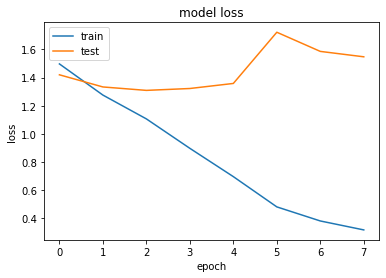

In [39]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [40]:
pred = (np.argmax(cl_model.predict(X_test_padded), axis=-1))

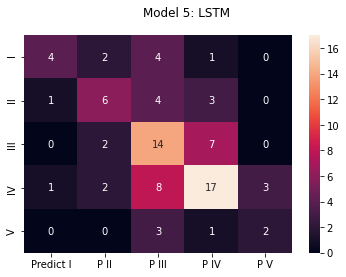

In [41]:
me.fn_confusion_matrix(title="Model 5: LSTM",y_test=y_test, y_predict= pred)

In [42]:
cl_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 50)           149400    
_________________________________________________________________
lstm (LSTM)                  (None, 100, 64)           29440     
_________________________________________________________________
flatten (Flatten)            (None, 6400)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               1638656   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 6

In [43]:
y_test=pd.DataFrame(y_test).replace({0:'I', 1:'II', 2:'III', 3:'IV', 4:'V'})
pred=pd.DataFrame(pred).replace({0:'I', 1:'II', 2:'III', 3:'IV', 4:'V'})

In [44]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           I       0.67      0.36      0.47        11
          II       0.50      0.43      0.46        14
         III       0.42      0.61      0.50        23
          IV       0.59      0.55      0.57        31
           V       0.40      0.33      0.36         6

    accuracy                           0.51        85
   macro avg       0.52      0.46      0.47        85
weighted avg       0.53      0.51      0.50        85

